# Gaussian Process error

## N-point Green's functions

In [1]:
import numpy as np

from qutip import *
from qutip.qip.operations import rx
from pylab import *

import functools
import itertools

from numba import njit, jit

In [260]:
def greens_plot(num_points, meas, corr_vec):
    f, a = plt.subplots(1, len(meas), sharex=True, sharey=True, figsize=(8 * len(meas), 6))
    for idx, (k, _) in enumerate(meas.items()):
        corr_vec = corr_vec_d[k]
        for corr in corr_vec:
            a[idx].plot(tlist, np.real(corr), alpha=0.5)
        a[idx].plot(tlist, np.mean(np.real(corr_vec), axis=0), 'r+', label='mean')

        a[idx].set_xlabel(r'$\tau$')
        a[idx].set_ylabel(fr'{num_points}-point correlation')

        title = fr'Correlation $\left<{k}(t + \tau), {k}(t)\right>$' if num_points == 2 else fr'Correlation $\left<{k}(t), {k}(t + \tau), {k}(t)\right>$'
        a[idx].set_title(title)

    f.legend()
    f.show()

In [6]:
# Classical stochastic parameterization of sigmax() rotation.
def gaussian_process(prev, i, mu, sigma, T):
    if i > T:
        return prev
    i += 1
    prev.append(np.random.normal(mu, sigma) * sigmax())
    return gaussian_process(prev, i, mu, sigma, T)


# Cached.
def hamiltonian(gp, t, *args):
    # t is rounded since we're working on the lattice.
    t = int(t)
    return gp[t]


# Prepare in sigmaz().
state0 = basis(2, 0)
# Hermitian observables.
meas = {
    r'\sigma_X': sigmax(),
    r'\sigma_Y': sigmay(),  # optimal
    r'\sigma_Z': sigmaz(),
    # r'\frac{1}{\sqrt{2}}(\sigma_X + \sigma_Y)': (sigmax() + sigmay() ) / np.sqrt(2),
}

# Number of independent GP chains to sample.
M = 100
# Lattice size (temporal)
T = 10
# Maximum temporal radius on lattice to compute two-point correlations.
TAU_MAX = 10
tlist = np.linspace(0, TAU_MAX - 1, TAU_MAX, dtype=np.int)

In [271]:
MU = 0
SIGMA = np.pi / 18

NUM_POINTS = 2
assert NUM_POINTS == 2 or NUM_POINTS == 3, "Green's must be 2- of 3-point."

expected_random_2sd_distance = np.sqrt(2 * SIGMA * 2 * T / np.pi)
assert expected_random_2sd_distance < np.pi/2, f"Random walk distance should remain bounded to hemisphere: expected {expected_random_2sd_distance} < {np.pi/2}"


def get_greens(m, num_points=2):
    corr_vec = []
    for i in range(M):
        # Sample GP.
        gp = gaussian_process([qeye(2)], 0, MU, SIGMA, 2 * T)
        h = functools.partial(hamiltonian, gp)
        greens = correlation_2op_1t if num_points == 2 else functools.partial(correlation_3op_1t, c_op=m)
        # Compute two-points.
        corr_vec.append(
            greens(H=h, state0=state0, taulist=tlist, c_ops=[Qobj([[0.0, 0.0],[0.0, 0.0]])], a_op=m, b_op=m)
        )
    return corr_vec


corr_vec_d = {}
for k, v in meas.items():
    corr_vec_d[k] = get_greens(v, num_points=NUM_POINTS)

In [306]:
theta = np.pi / 5

green_2 = lambda sigmai: rx(theta) * sigmai * rx(theta).dag() * sigmai * state0 * state0.dag()
green_3 = lambda sigmai: sigmai * green_2(sigmai)

print(green_2(sigmaz()).tr(), "\n")
print(green_2(sigmay()).tr(), "\n")

# Commutes with prepared state.
print(green_3(sigmaz()), "\n")
print((green_3(sigmaz())).tr(), "\n")
# Does not commute. Hence, distinction becomes apparent at 3-point.
print(green_3(sigmay()), "\n")
print((green_3(sigmay())).tr(), "\n")

0.8090169943749473 

0.8090169943749473 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.80901699+0.j         0.        +0.j        ]
 [0.        +0.58778525j 0.        +0.j        ]] 

0.8090169943749473 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.58778525+0.j          0.        +0.j        ]
 [ 0.        +0.80901699j  0.        +0.j        ]] 

-0.587785252292473 



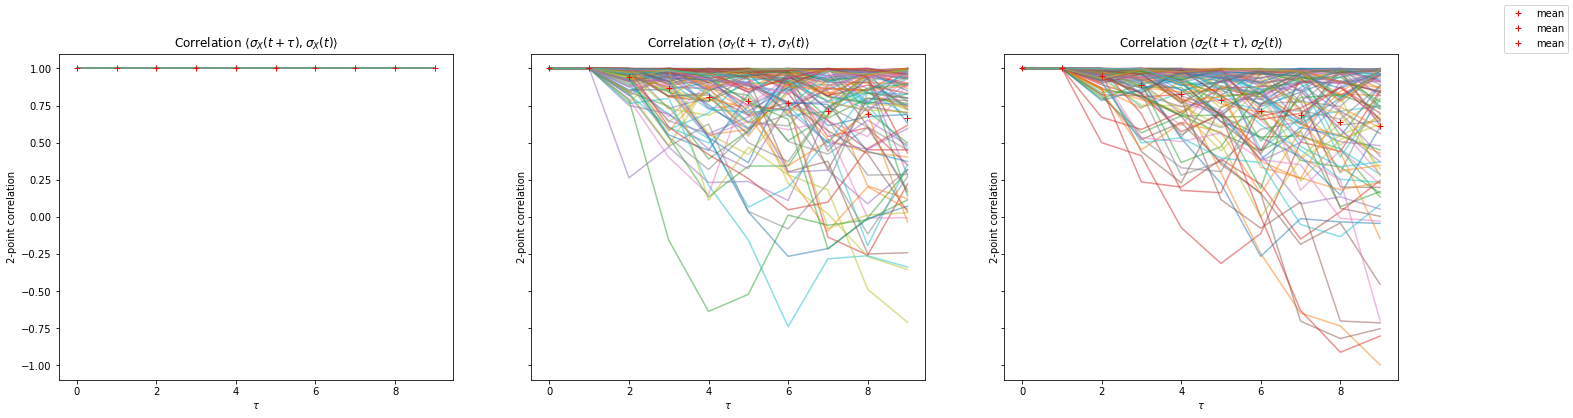

In [272]:
greens_plot(NUM_POINTS, meas, corr_vec)

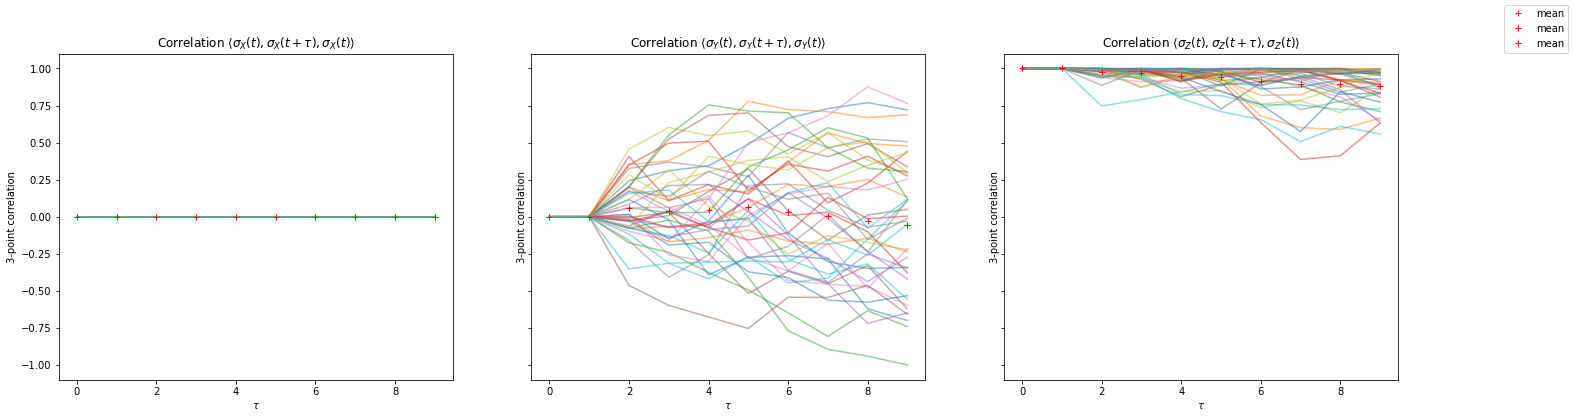

In [256]:
greens_plot(NUM_POINTS, meas, corr_vec)

## Keldysh

In [69]:
import keldysh_sim as kd
import keldysh_utils as kd_utils

import numpy as np
import altair as alt
import pandas as pd

from qutip import *

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Temporal lattice size.
T = 2
# Number of independent GP chains to sample.
M = 100
SIGMA = np.pi / 4
MU = 0

# sqrt(2SD * 2 * lattice_length / np.pi)
expected_random_2sd_distance = np.sqrt(2 * SIGMA * 2 * (2 * T) / np.pi)
print(f"Root-mean-square deviation: {expected_random_2sd_distance}")
# assert expected_random_2sd_distance < np.pi/2, f"Random walk distance should remain bounded to hemisphere: expected {expected_random_2sd_distance} < {np.pi/2}"
# Prepare in sigmaz().
state0 = np.array(basis(2, 0))
print(f"Prepared state: {state0}")

def get_eig(sigma_i):
    return np.array([np.array(e) for e in sigma_i.eigenstates()[1]])

# Hermitian observables.
meas = {
    r'\sigma_X': (np.array(sigmax()), get_eig(sigmax())),
    r'\sigma_Y': (np.array(sigmay()), get_eig(sigmay())),  # optimal
    r'\sigma_Z': (np.array(sigmaz()), get_eig(sigmaz())),
    r'\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z)': (np.array((sigmay() + sigmaz()) / np.sqrt(2)), get_eig((sigmay() + sigmaz()) / np.sqrt(2))),
}

meas_names = list(meas.keys())
meas_eigs = [v[1] for k, v in meas.items()]
keldysh_vec = kd.sample_gps(meas_names, meas_eigs, M, MU, SIGMA, T, state0)
# print(keldysh_vec)
keldysh_vec = kd_utils.qobj_to_numpy(keldysh_vec)
# print(keldysh_vec)

Root-mean-square deviation: 2.0
Prepared state: [[1.+0.j]
 [0.+0.j]]


In [96]:
kd_df = kd_utils.keldysh_vec_to_pd(keldysh_vec, T)

kd_df_mean = kd_df.groupby(['z', 'basis']).agg({'p(z)': ['mean']})

In [97]:
# Check that quasi-probability distributions are indeed normalized.
kd_df_mean.groupby(['basis']).sum()

,p(z)
,mean
basis,
\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z),1.0
\sigma_X,1.0
\sigma_Y,1.0
\sigma_Z,1.0


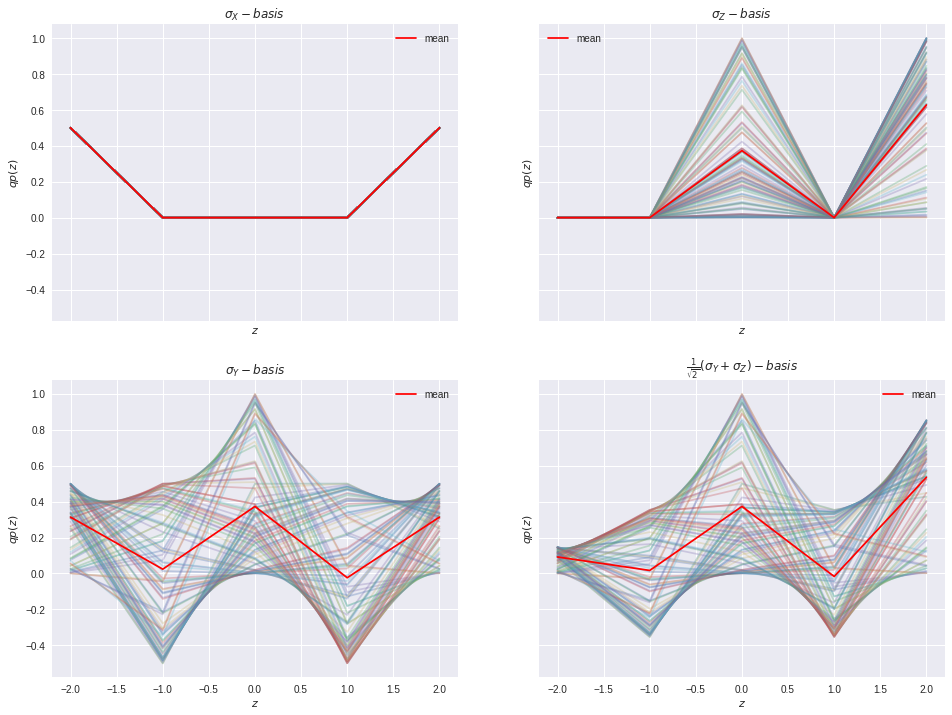

In [120]:
kd_utils.keldysh_plot(meas, keldysh_vec, T)

In [80]:
base = alt.Chart(kd_df).mark_line(opacity=0.5).encode(
    alt.X('z:Q'),
    alt.Y('p(z):Q'),
    alt.Column('basis:N'),
    alt.Color('random_gp:N', legend=None),
)

base

alt.Chart(...)